# Analysis of gene expression data

# I Data Retrieval
Data Retrieval was done using the RScript!

- Download Data (Thyroid cancer data)  


In [1]:
from pyunpack import Archive
import glob,os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy import stats
import statsmodels.stats.multitest as mt

from tqdm import tqdm
import networkx as nx

In [2]:
patients_C=pd.read_csv("TCGA-UCEC/TCGA-UCEC_rna_patients_C.txt",header=None)
patients_C.columns=['patients']
patients_N=pd.read_csv("TCGA-UCEC/TCGA-UCEC_rna_patients_N.txt",header=None)
patients_N.columns=['patients']

genes_C=pd.read_csv("TCGA-UCEC/TCGA-UCEC_rna_expr_data_C.txt",sep=' ')
genes_N=pd.read_csv("TCGA-UCEC/TCGA-UCEC_rna_expr_data_N.txt",sep=' ')


#clinical_data=pd.read_csv("TCGA-UCEC/TCGA-UCEC_clinical_data.txt")

In [3]:
clinical_data=pd.read_csv("TCGA-UCEC/TCGA-UCEC_clinical_data.txt",sep=';')

In [4]:
(clinical_data.shape)

(548, 1)

In [5]:
clinical_data.iloc[208:209]

,"submitter_id,year_of_diagnosis,classification_of_tumor,last_known_disease_status,updated_datetime,primary_diagnosis,tumor_stage,age_at_diagnosis,morphology,days_to_last_known_disease_status,days_to_last_follow_up,prior_treatment,state,days_to_recurrence,diagnosis_id,tumor_grade,figo_stage,icd_10_code,days_to_diagnosis,tissue_or_organ_of_origin,progression_or_recurrence,prior_malignancy,synchronous_malignancy,site_of_resection_or_biopsy,created_datetime,cigarettes_per_day,weight,alcohol_history,alcohol_intensity,bmi,years_smoked,exposure_id,height,gender,year_of_birth,race,days_to_birth,ethnicity,vital_status,demographic_id,age_at_index,year_of_death,days_to_death,treatments_pharmaceutical_treatment_type,treatments_pharmaceutical_treatment_id,treatments_pharmaceutical_therapeutic_agents,treatments_pharmaceutical_treatment_intent_type,treatments_pharmaceutical_treatment_or_therapy,treatments_pharmaceutical_days_to_treatment_start,treatments_pharmaceutical_treatment_effect,treatments_pharmaceutical_initial_disease_status,treatments_pharmaceutical_regimen_or_line_of_therapy,treatments_pharmaceutical_treatment_anatomic_site,treatments_pharmaceutical_treatment_outcome,treatments_pharmaceutical_days_to_treatment_end,treatments_radiation_treatment_type,treatments_radiation_treatment_id,treatments_radiation_therapeutic_agents,treatments_radiation_treatment_intent_type,treatments_radiation_treatment_or_therapy,treatments_radiation_days_to_treatment_start,treatments_radiation_treatment_effect,treatments_radiation_initial_disease_status,treatments_radiation_regimen_or_line_of_therapy,treatments_radiation_treatment_anatomic_site,treatments_radiation_treatment_outcome,treatments_radiation_days_to_treatment_end,bcr_patient_barcode,disease"
208,"TCGA-B5-A0K0,2008,not reported,not reported,20..."


In [6]:
print(patients_C.shape[0],'  --------> patients with cancer')
print(patients_N.shape[0],'  --------> patients without cancer')

551   --------> patients with cancer
35   --------> patients without cancer


In [7]:
print('Number of genes available -------->',len(set(genes_C.index).intersection(set(genes_N.index))))

Number of genes available --------> 56512


In [8]:
##Select only patients for whom cancer and normal tissue files are available.
patients_C_N=(set(patients_C.patients).intersection(set(patients_N.patients))) # consider 23 patients
print('Number of patients for whom cancer and normal tissue files are available -------->', len(patients_C_N))

patients_C_N

Number of patients for whom cancer and normal tissue files are available --------> 23


{'TCGA-AJ-A2QL',
 'TCGA-AJ-A3NC',
 'TCGA-AJ-A3NE',
 'TCGA-AJ-A3NH',
 'TCGA-AX-A05Y',
 'TCGA-AX-A0IZ',
 'TCGA-AX-A0J0',
 'TCGA-AX-A1CF',
 'TCGA-AX-A1CI',
 'TCGA-AX-A1CK',
 'TCGA-AX-A2H8',
 'TCGA-AX-A2HA',
 'TCGA-AX-A2HC',
 'TCGA-AX-A2HD',
 'TCGA-BG-A2AD',
 'TCGA-BG-A3EW',
 'TCGA-BG-A3PP',
 'TCGA-BK-A0CB',
 'TCGA-BK-A13C',
 'TCGA-BK-A4ZD',
 'TCGA-DI-A2QU',
 'TCGA-DI-A2QY',
 'TCGA-E6-A1M0'}

In [9]:
genes_N_T = genes_N.T 
genes_N_T['patient'] = list(genes_N_T.index)

patients_lst = genes_N_T.patient.apply(lambda x: x[:12])
genes_N_T['patient'] = patients_lst

genes_N_T.set_index('patient',drop=True,inplace=True)

genes_N = genes_N_T[genes_N_T.index.isin(patients_C_N)].T

In [10]:
genes_C_T = genes_C.T 
genes_C_T['patient'] = list(genes_C_T.index)

patients_lst = genes_C_T.patient.apply(lambda x: x[:12])
genes_C_T['patient'] = patients_lst

genes_C_T.set_index('patient',drop=True,inplace=True)

genes_C = genes_C_T[genes_C_T.index.isin(patients_C_N)].T

In [11]:
set(genes_C.index==genes_N.index) #check of order of genes is the same in both dataframes

{True}

In [12]:
print(genes_C.shape)
print(genes_N.shape)

(56512, 23)
(56512, 23)


In [13]:
genes_CN=genes_C.join(genes_N,lsuffix='_caller', rsuffix='_other',how='inner') #BOTH C and N

# II  Identify Differentially expressed genes

 

2. Identify Differentially Expressed Genes (DEGs) specifying the thresholds setting. Select the thresholds to obtain a subset of hundreds of genes: p-value should be less than or equal to 0.05 (it is suggested to apply a correction for multiple comparisons) and Fold Change greater than or equal to 1.2.


## Which genes are differentially expressed?


**Fold Change**
A first criterion can be to identify the genes whose expression in the two
groups of samples considered varies by a certain proportion (doubles,
halves, ...)

𝑓𝑜𝑙𝑑𝑐ℎ𝑎𝑛𝑔𝑒=$𝑙𝑜𝑔_2\frac{𝐸𝑥𝑝𝑟𝑐𝑜𝑛𝑑1}{𝐸𝑥𝑝𝑟𝑐𝑜𝑛𝑑2}$=2


Condition 1 - Normal

Condition 2 - Cancer

In [14]:
fold_df=np.log2(genes_C.sum(axis=1)/genes_N.sum(axis=1))
fold_df[fold_df>=2.4]#1.2 was not enough to reach subset of 500 coNCmbined with p-value 0.01 and correction

C:\Users\dusic\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


ENSG00000002726    4.444725
ENSG00000003249    2.793129
ENSG00000004809    2.791267
ENSG00000006059    3.139068
ENSG00000006118    3.533563
                     ...   
ENSG00000281379         inf
ENSG00000281696         inf
ENSG00000281809    5.244720
ENSG00000281856         inf
ENSG00000281863         inf
Length: 5972, dtype: float64

In [15]:
fold_sort_df=pd.DataFrame(fold_df[fold_df>=2.4]) ##Decide on this threshold and p-value threshold
fold_sort_df.columns=['fold_value']


#drop nan and inf(when log is not defined--> log0)
fold_sort_df.dropna(inplace=True)
fold_sort_df=fold_sort_df[(fold_sort_df.fold_value!=np.inf)]
fold_sort_df=fold_sort_df.sort_values(['fold_value'],ascending=False)

## Statistical tests
## Student’s t test for two conditions/groups (control vs treated)

In [16]:
fold_sort_df.index #USE JUST THESE GENES which have fold value >= chosen threshold

Index(['ENSG00000164816', 'ENSG00000125363', 'ENSG00000107187',
       'ENSG00000215853', 'ENSG00000249082', 'ENSG00000258314',
       'ENSG00000107807', 'ENSG00000178172', 'ENSG00000136352',
       'ENSG00000075388',
       ...
       'ENSG00000100122', 'ENSG00000269353', 'ENSG00000229749',
       'ENSG00000258599', 'ENSG00000225563', 'ENSG00000228974',
       'ENSG00000234030', 'ENSG00000137571', 'ENSG00000223703',
       'ENSG00000229770'],
      dtype='object', length=3046)

In [17]:
genes_C_reduced=genes_C[genes_C.index.isin(fold_sort_df.index)]
genes_N_reduced=genes_N[genes_N.index.isin(fold_sort_df.index)]

Because of the fold change we reduced # of DEG 

In [18]:
print('From ',genes_C.shape[0],'to ------->',genes_C_reduced.shape[0],' in the Primary solid Tumor data')
print('From ',genes_N.shape[0],'to ------->',genes_N_reduced.shape[0],' in the Solid Tissue Normal data')

From  56512 to -------> 3046  in the Primary solid Tumor data
From  56512 to -------> 3046  in the Solid Tissue Normal data


### Performing t-tests for each gene for both conditions 

In [19]:
stat_lst=[]
pvalue_lst=[]
ttest_df=pd.DataFrame(columns=['gene','statistic','pvalue'])
for i in tqdm(range(genes_C_reduced.shape[0])):# FOR ALL
    res=stats.ttest_ind(genes_C_reduced.iloc[i,:],genes_N_reduced.iloc[i,:])
    stat_lst.append(res[0])
    pvalue_lst.append(res[1])
    ttest_df=ttest_df.append({'gene':genes_C_reduced.index[i],'statistic':res[0],'pvalue':res[1]},ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████| 3046/3046 [00:24<00:00, 123.33it/s]


In [20]:
ttest_df[ttest_df.pvalue<0.01]

,gene,statistic,pvalue
1,ENSG00000003249,7.066961,9.120604e-09
4,ENSG00000006118,7.434610,2.650385e-09
5,ENSG00000006377,5.937346,4.171373e-07
7,ENSG00000007968,6.258298,1.407119e-07
10,ENSG00000011332,3.661125,6.697789e-04
...,...,...,...
3017,ENSG00000279741,3.710128,5.783761e-04
3020,ENSG00000279949,2.734869,8.960293e-03
3024,ENSG00000280027,5.339130,3.123190e-06
3029,ENSG00000280114,3.004873,4.374467e-03


In [21]:
# HOW many? DEG pairs
ttest_df[ttest_df.pvalue<0.01].shape[0]

852

Correction method for p-values used:
        
        • FDR (False Discovery Rate): check if the k th ordered p value is larger
          than (k × a)/N  --->Benjamini/Hochberg (non-negative)
          


In [22]:
corr=mt.multipletests(ttest_df.pvalue, alpha=0.01, method='fdr_bh', is_sorted=False, returnsorted=False) 
#fdr_bh : Benjamini/Hochberg (non-negative)

In [23]:
# after applied correction

In [24]:
after_correction=ttest_df[corr[0]]
after_correction.shape[0]

554

In [25]:
after_correction[after_correction.pvalue<0.01] #check

,gene,statistic,pvalue
1,ENSG00000003249,7.066961,9.120604e-09
4,ENSG00000006118,7.434610,2.650385e-09
5,ENSG00000006377,5.937346,4.171373e-07
7,ENSG00000007968,6.258298,1.407119e-07
10,ENSG00000011332,3.661125,6.697789e-04
...,...,...,...
3006,ENSG00000279368,5.218766,4.666745e-06
3007,ENSG00000279379,5.393372,2.604904e-06
3011,ENSG00000279511,3.503523,1.067529e-03
3017,ENSG00000279741,3.710128,5.783761e-04


In [26]:
after_correction.gene[after_correction.gene.index[:2]].values

array(['ENSG00000003249', 'ENSG00000006118'], dtype=object)

In [27]:
genes_C[genes_C.index=='ENSG00000000003']

patient,TCGA-BK-A4ZD,TCGA-BK-A13C,TCGA-BG-A3PP,TCGA-AX-A2HD,TCGA-AX-A05Y,TCGA-BG-A2AD,TCGA-AJ-A3NE,TCGA-AX-A2HA,TCGA-AX-A1CI,TCGA-AJ-A2QL,...,TCGA-AJ-A3NH,TCGA-AX-A0J0,TCGA-AX-A2H8,TCGA-AX-A1CF,TCGA-AX-A2HC,TCGA-E6-A1M0,TCGA-AX-A1CK,TCGA-BG-A3EW,TCGA-AJ-A3NC,TCGA-DI-A2QY
ENSG00000000003,25.01986,16.382546,23.099338,22.797023,15.560505,19.880973,23.422275,9.947205,13.210778,69.24041,...,62.117937,25.828921,28.49756,17.002542,24.369133,22.64943,14.691229,22.054274,21.268098,41.604673


In [28]:
#example of 3 DEG in normal and cancer tissue sample
def plotGenes(example_genes):
    plt.figure(figsize=(20,10)) 
    for idx,ex in enumerate(example_genes):
        tissue_C = genes_CN[genes_CN.index==example_genes[idx]].values.tolist()[0]
#        tissue_N = genes_N[genes_N.index==example_genes[idx]].values.tolist()[0]

        plt.plot(range(1,len(tissue_C)+1),tissue_C)


    plt.legend(example_genes)
    plt.axvline(5, linewidth=780,  color = 'r',alpha=0.05)
    plt.axvline(40, linewidth=800,  color = 'b',alpha=0.05)
    plt.show()

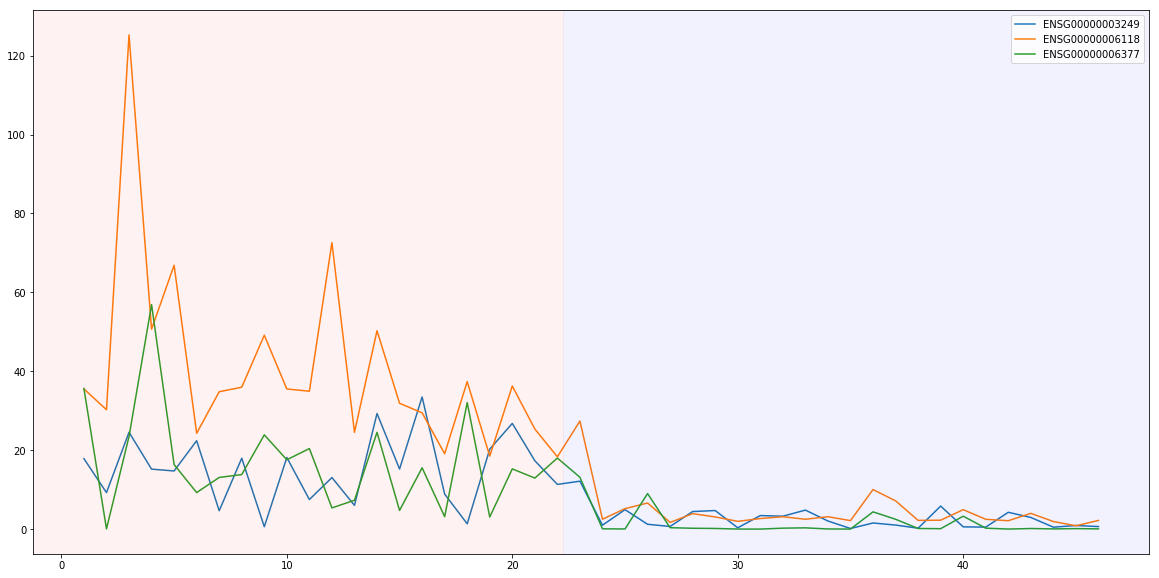

In [29]:
DEG_examples=list(after_correction.gene[after_correction.gene.index[:3]])
plotGenes(DEG_examples)

In [30]:
fdf=pd.DataFrame(fold_df[fold_df<=1])
fdf.columns=['fold_value']


#drop nan and inf(when log is not defined--> log0)
fdf.dropna(inplace=True)
fdf=fdf[(fdf.fold_value!=np.inf)]
fdf=fdf.sort_values(['fold_value'],ascending=True)

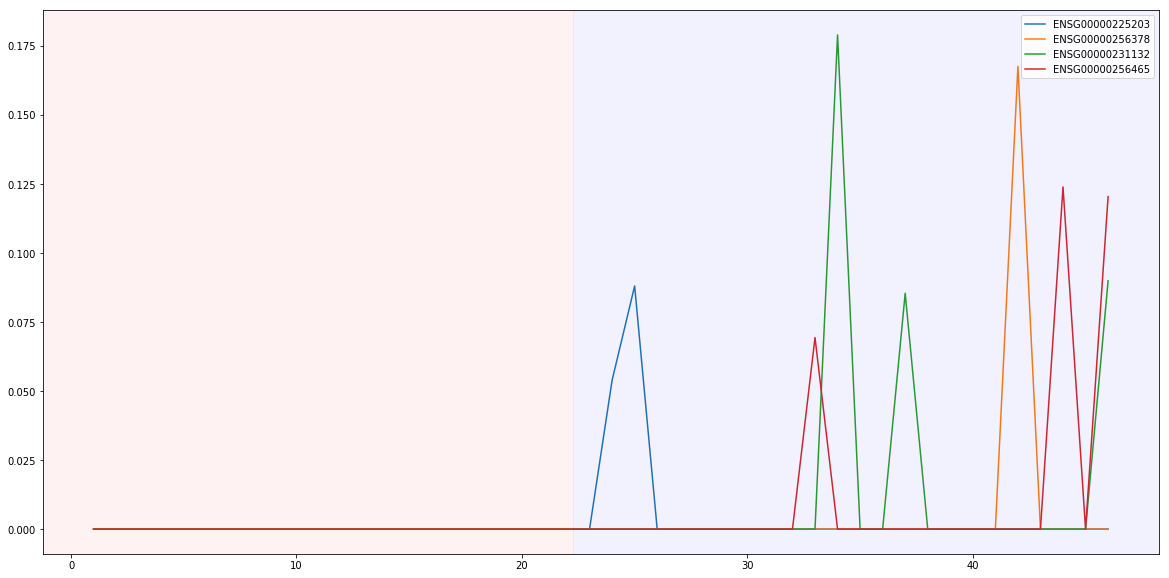

In [31]:
Non_DEG_examples=list(fdf.index[[0,3,4,5]])
plotGenes(Non_DEG_examples)

# III Gene co-expression 
 

## Which and how many genes are co expressed?

3. Using only DEGs, compute the gene co-expression networks related to the 2 conditions (cancer, normal) considering:
        o Pearson’s correlation;
        o Binary adjacency matrix where aij=0 if |R|<0.7 (where R is the Pearson correlation coefficient).

In [32]:
chosen_genes_C=genes_C[genes_C.index.isin(after_correction.gene.values)]
chosen_genes_N=genes_N[genes_N.index.isin(after_correction.gene.values)]

In [33]:
set(chosen_genes_N.columns).intersection(chosen_genes_C.columns)

{'TCGA-AJ-A2QL',
 'TCGA-AJ-A3NC',
 'TCGA-AJ-A3NE',
 'TCGA-AJ-A3NH',
 'TCGA-AX-A05Y',
 'TCGA-AX-A0IZ',
 'TCGA-AX-A0J0',
 'TCGA-AX-A1CF',
 'TCGA-AX-A1CI',
 'TCGA-AX-A1CK',
 'TCGA-AX-A2H8',
 'TCGA-AX-A2HA',
 'TCGA-AX-A2HC',
 'TCGA-AX-A2HD',
 'TCGA-BG-A2AD',
 'TCGA-BG-A3EW',
 'TCGA-BG-A3PP',
 'TCGA-BK-A0CB',
 'TCGA-BK-A13C',
 'TCGA-BK-A4ZD',
 'TCGA-DI-A2QU',
 'TCGA-DI-A2QY',
 'TCGA-E6-A1M0'}

In [34]:
all_chosen=chosen_genes_C.T.append(chosen_genes_N.T)#chosen_genes_C.append(chosen_genes_N)
all_chosen.shape

(46, 554)

In [35]:
all_chosen=all_chosen.apply(lambda x: x.astype('float64'))
all_chosen.shape

(46, 554)

In [36]:
corr_matrix=all_chosen.corr(method = 'pearson').apply(lambda x: abs(x))  ##  o Pearson’s correlation matrix

In [37]:
corr_matrix #diagonal needs to have zeros and 1 if Pearson correlation coefficient is > 0.7

,ENSG00000003249,ENSG00000006118,ENSG00000006377,ENSG00000007968,ENSG00000011332,ENSG00000011426,ENSG00000013810,ENSG00000024526,ENSG00000029993,ENSG00000034053,...,ENSG00000278588,ENSG00000278637,ENSG00000278677,ENSG00000278828,ENSG00000278952,ENSG00000279368,ENSG00000279379,ENSG00000279511,ENSG00000279741,ENSG00000280027
ENSG00000003249,1.000000,0.623047,0.491290,0.406878,0.294790,0.625329,0.495105,0.462757,0.629382,0.368299,...,0.419605,0.463108,0.590354,0.474746,0.447234,0.654227,0.579634,0.305549,0.353552,0.420990
ENSG00000006118,0.623047,1.000000,0.641670,0.448073,0.367295,0.532663,0.493155,0.554702,0.607789,0.296395,...,0.263436,0.334377,0.537053,0.597155,0.502930,0.321876,0.435388,0.244397,0.173367,0.252879
ENSG00000006377,0.491290,0.641670,1.000000,0.698441,0.570566,0.700763,0.516829,0.567386,0.545046,0.218272,...,0.270112,0.212142,0.292117,0.319959,0.418589,0.448620,0.468524,0.256095,0.221458,0.318834
ENSG00000007968,0.406878,0.448073,0.698441,1.000000,0.792960,0.727305,0.747273,0.813826,0.609709,0.409727,...,0.397465,0.450436,0.321317,0.279847,0.221941,0.644363,0.486225,0.489780,0.396584,0.276362
ENSG00000011332,0.294790,0.367295,0.570566,0.792960,1.000000,0.480141,0.542527,0.718052,0.565887,0.268076,...,0.271142,0.311495,0.253185,0.276087,0.174157,0.405570,0.465138,0.290515,0.507044,0.271016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000279368,0.654227,0.321876,0.448620,0.644363,0.405570,0.702879,0.560068,0.672562,0.541474,0.343152,...,0.305335,0.400412,0.296008,0.148079,0.277786,1.000000,0.469844,0.597034,0.269448,0.241161
ENSG00000279379,0.579634,0.435388,0.468524,0.486225,0.465138,0.488270,0.347687,0.485807,0.574769,0.337916,...,0.750817,0.468362,0.705217,0.633527,0.606923,0.469844,1.000000,0.244986,0.478042,0.524115
ENSG00000279511,0.305549,0.244397,0.256095,0.489780,0.290515,0.495422,0.609486,0.596444,0.588221,0.314694,...,0.217556,0.516309,0.260871,0.054799,0.242105,0.597034,0.244986,1.000000,0.125471,0.125586
ENSG00000279741,0.353552,0.173367,0.221458,0.396584,0.507044,0.382498,0.245387,0.384599,0.312050,0.610224,...,0.496971,0.232511,0.494685,0.302911,0.066759,0.269448,0.478042,0.125471,1.000000,0.798060


In [38]:
def adj_method(x):
    if x>0.7:        #0.7
        return 1
    else:
        return 0

In [39]:
## o Binary adjacency matrix where aij=0 if |R|<0.7 (where R is the Pearson correlation coefficient).

In [40]:
adj_matrix=corr_matrix.copy()
np.fill_diagonal(adj_matrix.values, 0)

for col in adj_matrix.columns:
    adj_matrix[col]=adj_matrix[col].apply(adj_method)

In [41]:
def corrAndAdj(data):
    corr_matrix=data.corr(method = 'pearson').apply(lambda x: abs(x))  ##  o Pearson’s correlation matrix
    adj_matrix=corr_matrix.copy()
    np.fill_diagonal(adj_matrix.values, 0)
    def adj_method(x):
        if x>0.7:
            return 1
        else:
            return 0
    adj_matrix=corr_matrix.copy()
    for col in adj_matrix.columns:
        adj_matrix[col]=adj_matrix[col].apply(adj_method)
    return corr_matrix,adj_matrix

In [42]:
corr_matrix_N,adj_matrix_N = corrAndAdj(chosen_genes_N.T)
corr_matrix_C,adj_matrix_C = corrAndAdj(chosen_genes_C.T)

In [43]:
corr_matrix_N

,ENSG00000003249,ENSG00000006118,ENSG00000006377,ENSG00000007968,ENSG00000011332,ENSG00000011426,ENSG00000013810,ENSG00000024526,ENSG00000029993,ENSG00000034053,...,ENSG00000278588,ENSG00000278637,ENSG00000278677,ENSG00000278828,ENSG00000278952,ENSG00000279368,ENSG00000279379,ENSG00000279511,ENSG00000279741,ENSG00000280027
ENSG00000003249,1.000000,0.017808,0.213013,0.412694,0.343431,0.065174,0.252663,0.075194,0.597185,0.526400,...,0.522902,0.069166,0.072462,0.401859,0.287426,0.433269,0.098623,0.015333,0.234701,0.184491
ENSG00000006118,0.017808,1.000000,0.712782,0.154842,0.074382,0.225122,0.215487,0.153901,0.326884,0.554402,...,0.179315,0.084653,0.068426,0.073350,0.025862,0.226884,0.315380,0.037924,0.622494,0.551776
ENSG00000006377,0.213013,0.712782,1.000000,0.011927,0.310430,0.245219,0.150265,0.215891,0.210331,0.353585,...,0.036376,0.152598,0.140777,0.237256,0.105803,0.287152,0.402387,0.033210,0.776529,0.963446
ENSG00000007968,0.412694,0.154842,0.011927,1.000000,0.405582,0.672918,0.792039,0.738153,0.346088,0.564076,...,0.188287,0.048487,0.092103,0.315275,0.217435,0.324619,0.030093,0.056296,0.315166,0.009394
ENSG00000011332,0.343431,0.074382,0.310430,0.405582,1.000000,0.038913,0.343014,0.043745,0.300457,0.290606,...,0.111062,0.423870,0.452431,0.075459,0.130760,0.047971,0.049899,0.012697,0.121472,0.335538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000279368,0.433269,0.226884,0.287152,0.324619,0.047971,0.465948,0.179008,0.461540,0.491188,0.491022,...,0.451128,0.008594,0.033681,0.058732,0.081292,1.000000,0.265205,0.006047,0.507685,0.258257
ENSG00000279379,0.098623,0.315380,0.402387,0.030093,0.049899,0.107529,0.127504,0.229968,0.664261,0.316393,...,0.323595,0.341135,0.339167,0.137306,0.046339,0.265205,1.000000,0.235304,0.371877,0.404006
ENSG00000279511,0.015333,0.037924,0.033210,0.056296,0.012697,0.073415,0.126560,0.066412,0.099454,0.110140,...,0.282633,0.123935,0.355424,0.211875,0.121058,0.006047,0.235304,1.000000,0.018508,0.037867
ENSG00000279741,0.234701,0.622494,0.776529,0.315166,0.121472,0.581886,0.379752,0.602699,0.281456,0.418231,...,0.190241,0.016479,0.207443,0.333405,0.155412,0.507685,0.371877,0.018508,1.000000,0.694228


In [44]:
>>> G = nx.from_pandas_adjacency(adj_matrix)
>>> G.name = 'Graph from pandas adjacency matrix'
>>> print(nx.info(G))

Name: Graph from pandas adjacency matrix
Type: Graph
Number of nodes: 554
Number of edges: 14524
Average degree:  52.4332


C:\Users\dusic\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


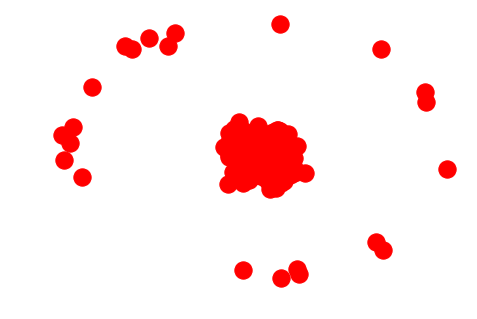

In [45]:
>>> nx.draw(G)

In [46]:
def show_graph_with_labels(adjacency_matrix):
    plt.figure(figsize=(20,25)) 
    mylabels={}
    for idx,val in enumerate(adjacency_matrix.index):
           mylabels[idx]=val
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=2, labels=mylabels, with_labels=True)
    plt.show()

In [47]:
adj_matrix_N

,ENSG00000003249,ENSG00000006118,ENSG00000006377,ENSG00000007968,ENSG00000011332,ENSG00000011426,ENSG00000013810,ENSG00000024526,ENSG00000029993,ENSG00000034053,...,ENSG00000278588,ENSG00000278637,ENSG00000278677,ENSG00000278828,ENSG00000278952,ENSG00000279368,ENSG00000279379,ENSG00000279511,ENSG00000279741,ENSG00000280027
ENSG00000003249,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000006118,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000006377,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
ENSG00000007968,0,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000011332,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000279368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
ENSG00000279379,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
ENSG00000279511,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
ENSG00000279741,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


C:\Users\dusic\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


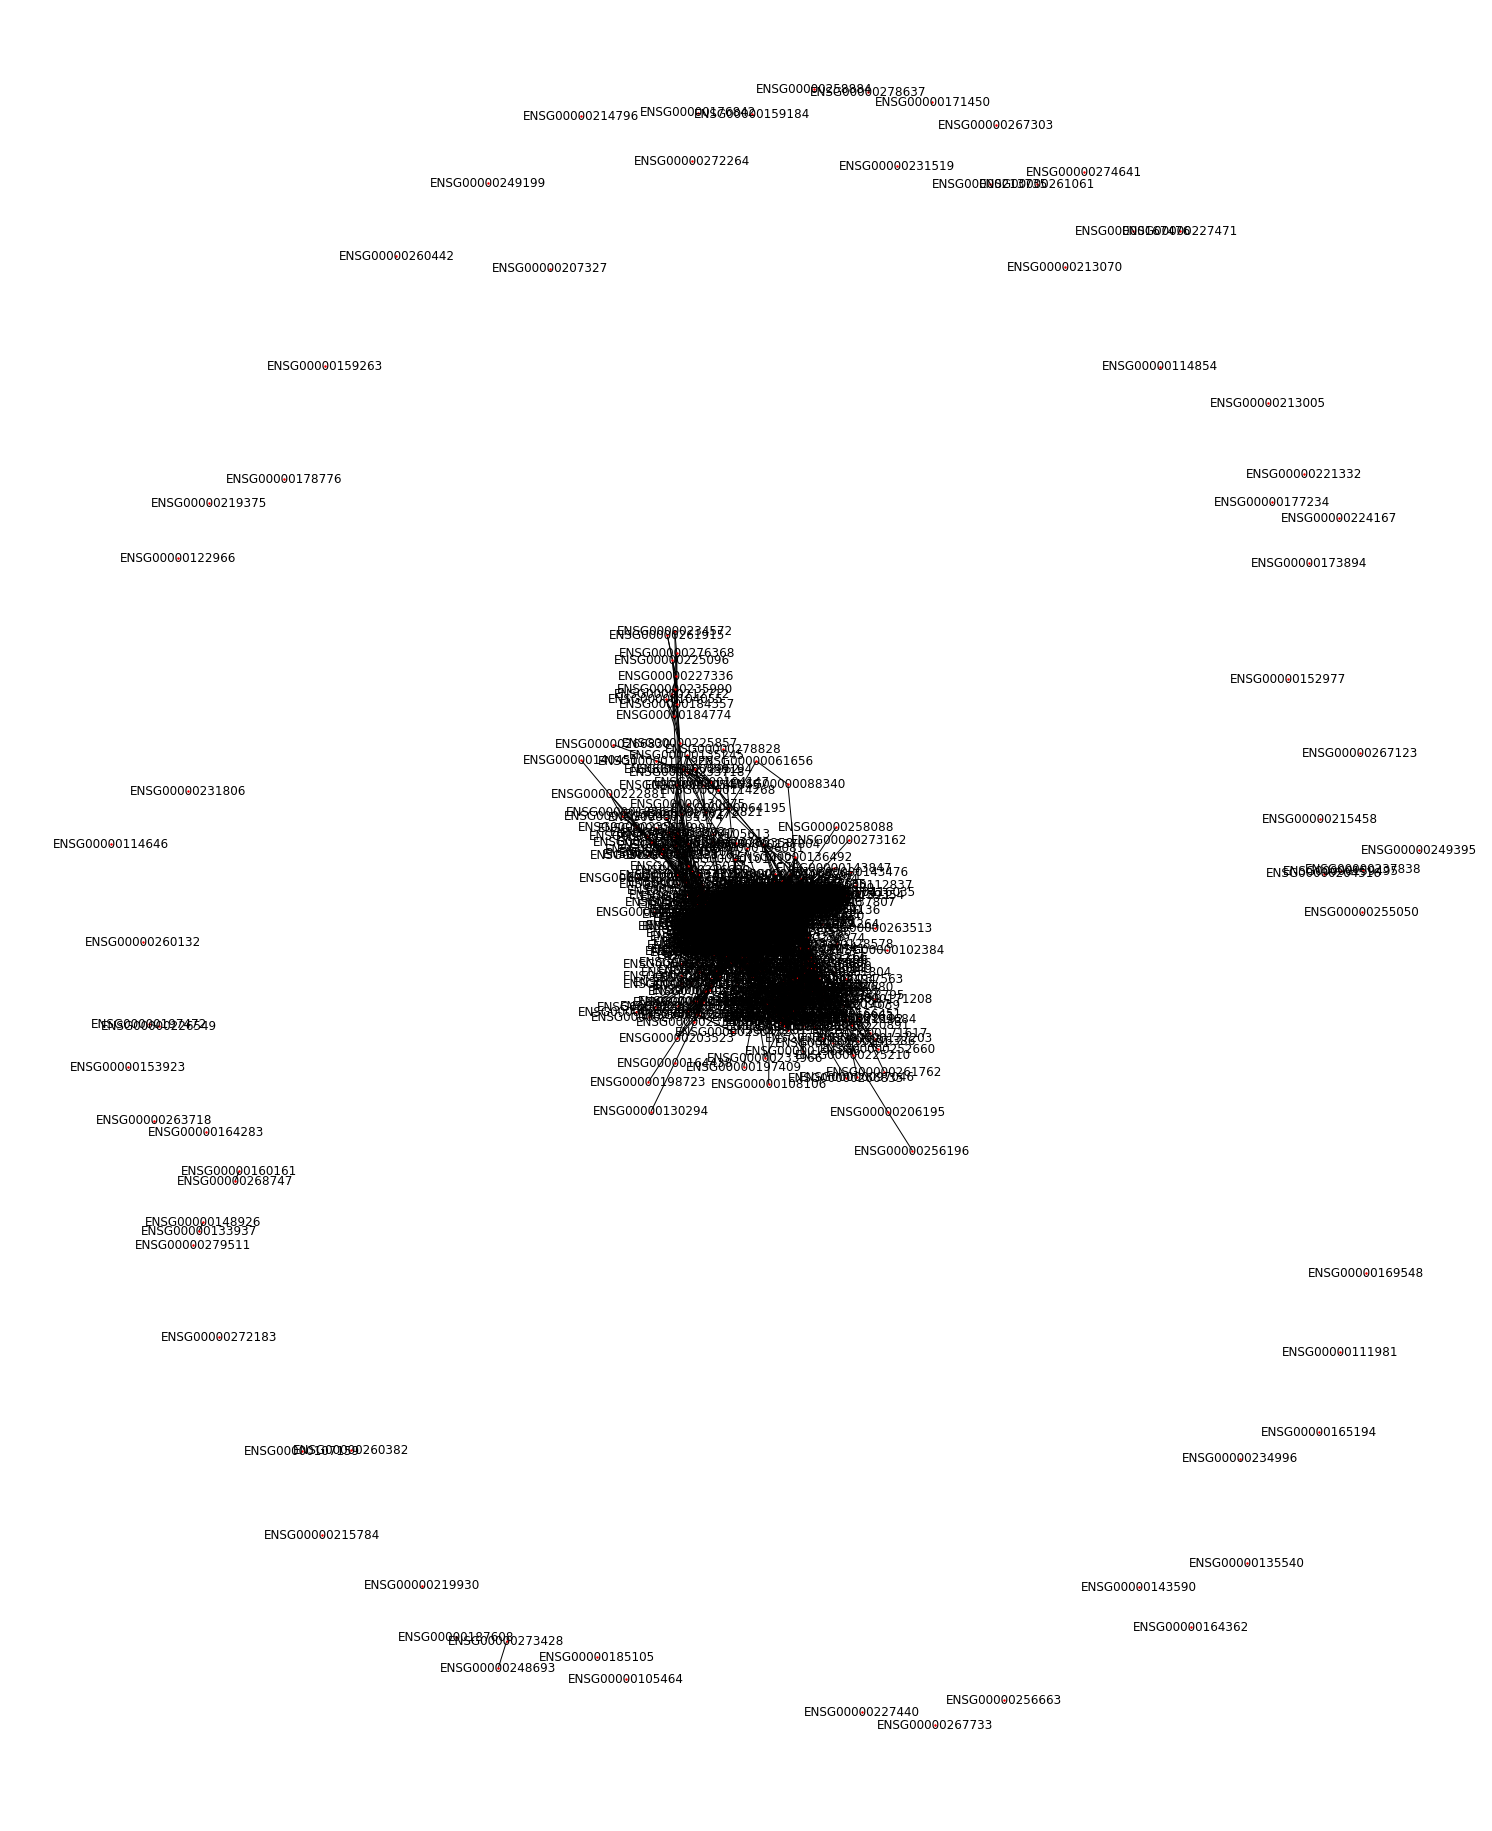

In [48]:
show_graph_with_labels(adj_matrix_N)

C:\Users\dusic\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


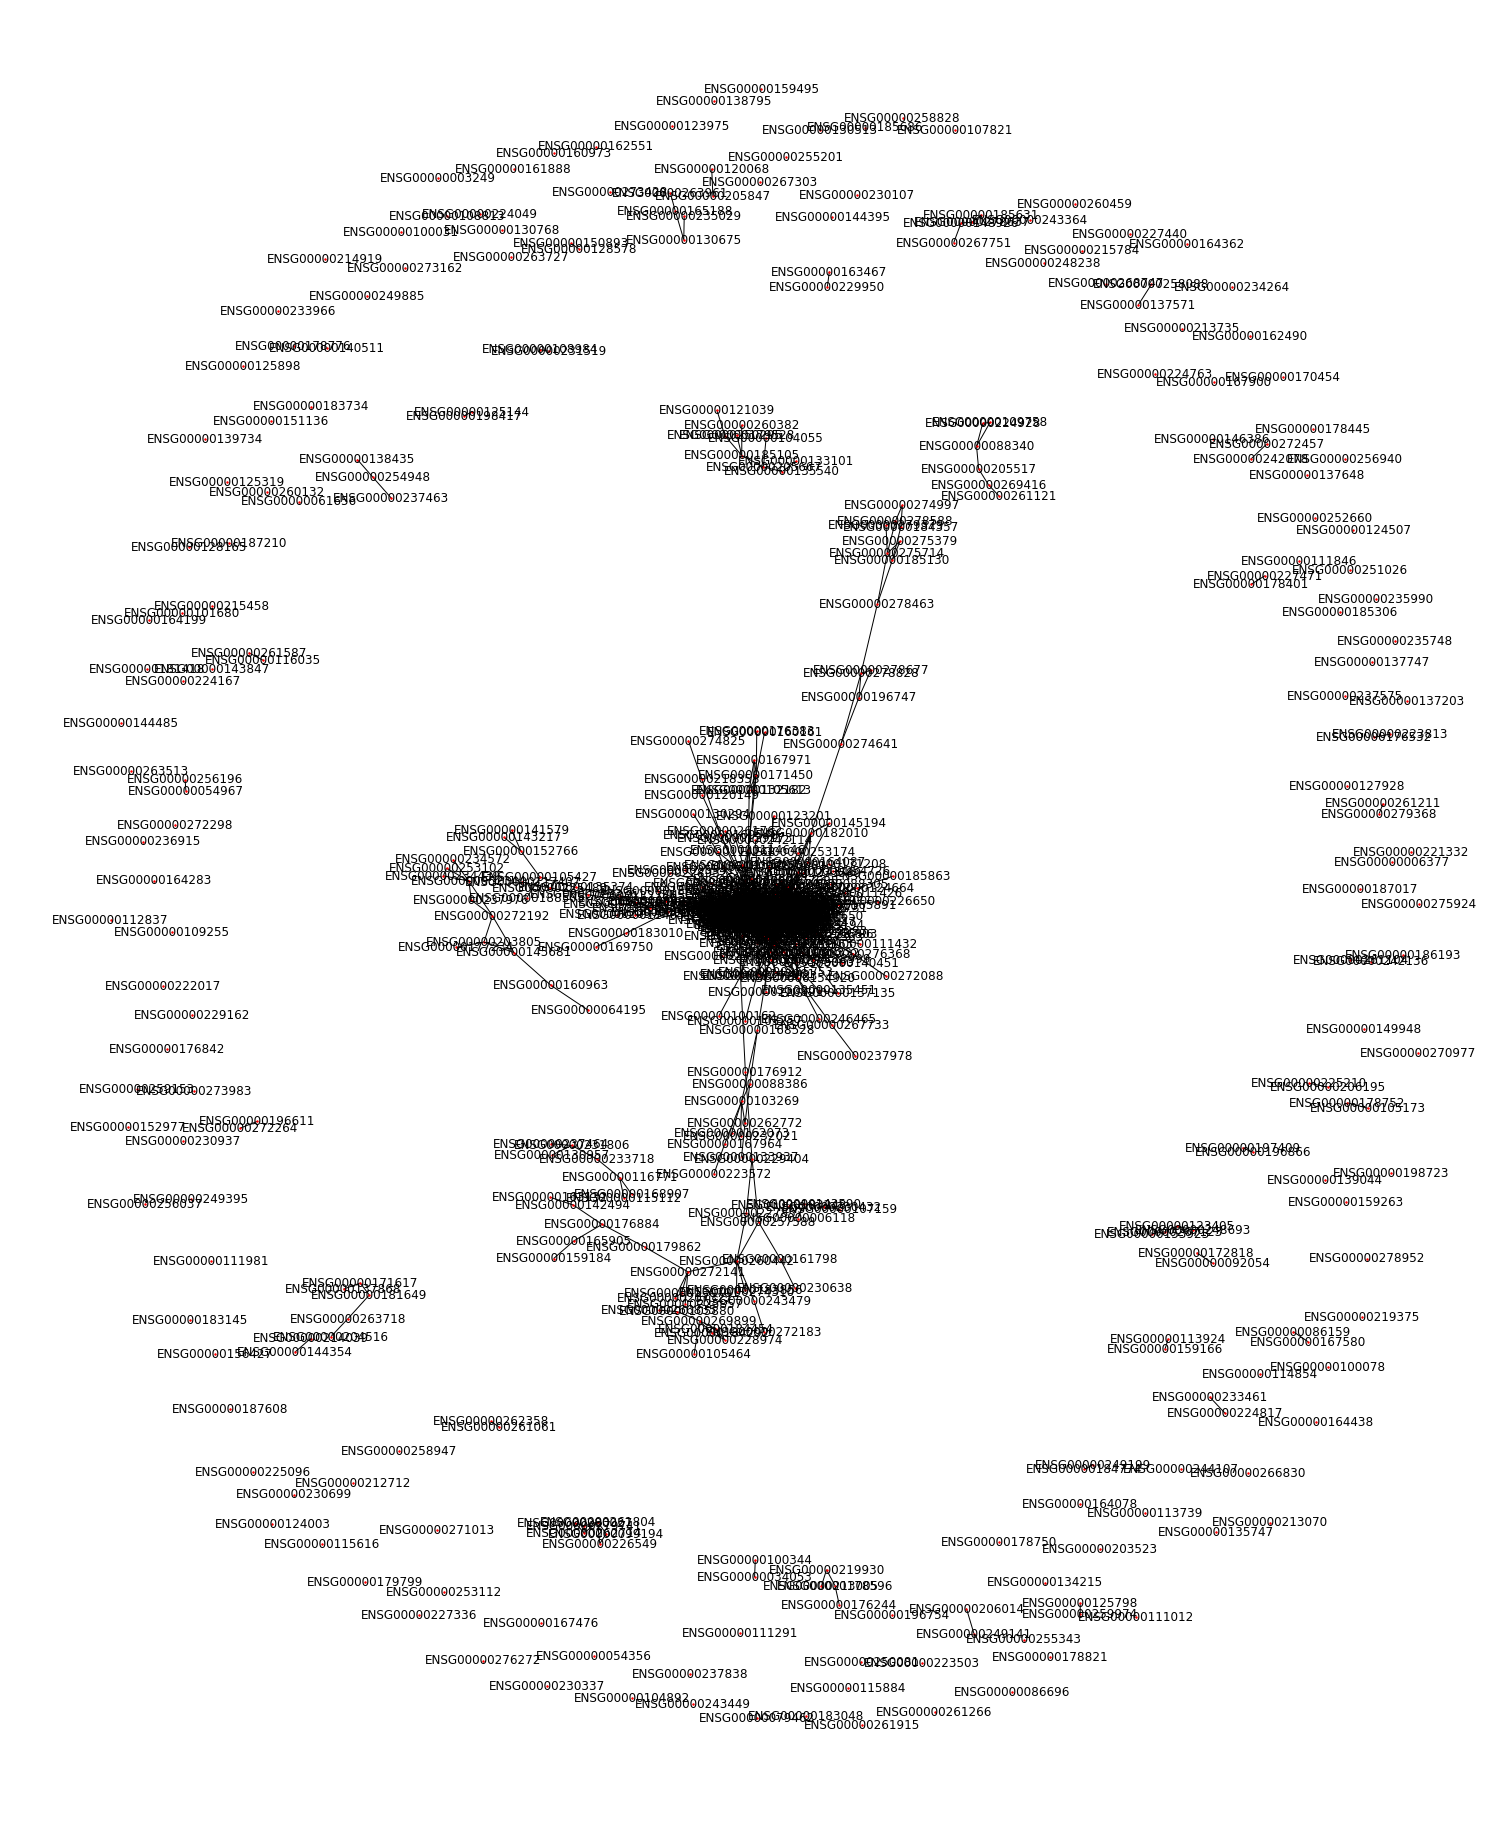

In [49]:
show_graph_with_labels(adj_matrix_C)

Banuska and Melis and check what I did before hahaa as I also should

4. Compute the degree index and find the hubs (5% of the nodes with highest degree values)
5. Compare hubs sets related to the two condition (cancer, normal) and identify the hubs characterizing only cancer tissue.

In [50]:
(adj_matrix_C.sum()).sum() - 226

7836

The method below computes degrees of nodes and returns list of hubs.
If i got it correctly, we dont need to compute shortest pathes or smth, we just need to take into consideration nodes which has the highest values of degree

In [51]:
def top_k(adj_matr): # method for  4th question
    idx_i, idx_j = np.where(adj_matr==1)
    idx_i, idx_j = list(idx_i), list(idx_j)
    Edges = [(adj_matr.index[idx_i[i]],adj_matr.index[idx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=idx_j[i])]
    out_degrees_of_nodes={'1':0}
    in_degrees_of_nodes={'1':0}
    for i in range(len(Edges)):
        if Edges[i][0] in out_degrees_of_nodes.keys():
            out_degrees_of_nodes[Edges[i][0]]=out_degrees_of_nodes[Edges[i][0]]+1
        else:
            out_degrees_of_nodes[Edges[i][0]]=1
        if Edges[i][1] in in_degrees_of_nodes.keys():
            in_degrees_of_nodes[Edges[i][1]]=in_degrees_of_nodes[Edges[i][1]]+1
        else:
            in_degrees_of_nodes[Edges[i][1]]=1
    del in_degrees_of_nodes['1']
    del out_degrees_of_nodes['1']
    print("in_degree")
    print(np.sum(list(in_degrees_of_nodes.values())))
    print("out_degree")
    print(np.sum(list(out_degrees_of_nodes.values())))
    # results shows that we have undirected graph
    check=[]
    for i in in_degrees_of_nodes.keys():
        check.append(in_degrees_of_nodes[i]==out_degrees_of_nodes[i])
    print(set(check))
    top_5_percent = int(len(list(adj_matr.index))*0.05)
    sorted_list = sorted(in_degrees_of_nodes.items(), key=lambda x: x[1], reverse=True)
    return sorted_list[:top_5_percent]

In [52]:
hubs_C = top_k(adj_matrix_C)

in_degree
7508
out_degree
7508
{True}


In [53]:
hubs_C

[('ENSG00000121152', 100),
 ('ENSG00000085840', 96),
 ('ENSG00000161800', 96),
 ('ENSG00000090889', 96),
 ('ENSG00000163808', 95),
 ('ENSG00000186871', 94),
 ('ENSG00000137807', 94),
 ('ENSG00000147536', 92),
 ('ENSG00000184661', 92),
 ('ENSG00000138160', 91),
 ('ENSG00000051341', 90),
 ('ENSG00000088325', 88),
 ('ENSG00000065328', 87),
 ('ENSG00000109674', 86),
 ('ENSG00000146670', 85),
 ('ENSG00000137804', 83),
 ('ENSG00000075218', 82),
 ('ENSG00000166851', 82),
 ('ENSG00000111602', 81),
 ('ENSG00000165480', 81),
 ('ENSG00000129195', 80),
 ('ENSG00000154839', 79),
 ('ENSG00000102384', 78),
 ('ENSG00000145386', 78),
 ('ENSG00000035499', 76),
 ('ENSG00000169679', 74),
 ('ENSG00000176890', 74)]

In [54]:
hubs_N = top_k(adj_matrix_N)

in_degree
17746
out_degree
17746
{True}


In [55]:
hubs_N

[('ENSG00000111247', 116),
 ('ENSG00000156970', 115),
 ('ENSG00000165480', 114),
 ('ENSG00000198826', 114),
 ('ENSG00000112742', 111),
 ('ENSG00000122952', 111),
 ('ENSG00000138160', 110),
 ('ENSG00000137812', 109),
 ('ENSG00000138180', 109),
 ('ENSG00000165304', 109),
 ('ENSG00000072571', 108),
 ('ENSG00000121152', 108),
 ('ENSG00000129810', 108),
 ('ENSG00000145386', 108),
 ('ENSG00000176890', 108),
 ('ENSG00000035499', 107),
 ('ENSG00000075218', 107),
 ('ENSG00000105011', 107),
 ('ENSG00000109805', 107),
 ('ENSG00000169607', 107),
 ('ENSG00000111206', 106),
 ('ENSG00000134690', 106),
 ('ENSG00000166851', 106),
 ('ENSG00000131747', 105),
 ('ENSG00000148773', 105),
 ('ENSG00000166803', 105),
 ('ENSG00000112984', 104)]

In [56]:
# the 5th question of our project, just to get difference, it seems
# it is totally different

In [57]:
set(hubs_C).difference(set(hubs_N))

{('ENSG00000035499', 76),
 ('ENSG00000051341', 90),
 ('ENSG00000065328', 87),
 ('ENSG00000075218', 82),
 ('ENSG00000085840', 96),
 ('ENSG00000088325', 88),
 ('ENSG00000090889', 96),
 ('ENSG00000102384', 78),
 ('ENSG00000109674', 86),
 ('ENSG00000111602', 81),
 ('ENSG00000121152', 100),
 ('ENSG00000129195', 80),
 ('ENSG00000137804', 83),
 ('ENSG00000137807', 94),
 ('ENSG00000138160', 91),
 ('ENSG00000145386', 78),
 ('ENSG00000146670', 85),
 ('ENSG00000147536', 92),
 ('ENSG00000154839', 79),
 ('ENSG00000161800', 96),
 ('ENSG00000163808', 95),
 ('ENSG00000165480', 81),
 ('ENSG00000166851', 82),
 ('ENSG00000169679', 74),
 ('ENSG00000176890', 74),
 ('ENSG00000184661', 92),
 ('ENSG00000186871', 94)}